# Fraud Detection in Electricity and Gas Consumption Challenge

This is a simple starter notebook based on the tutorial prepared by Joy Wawira. Check out the article [here](https://zindi.africa/learn/fraud-detection-in-electricity-and-gas-consumption-challenge-tutorial) for a more detailed description of the steps taken.

This notebook covers:
- Downloading the data straight from Zindi and onto colab
- Loading the data and carrying out simple EDA to understand the data and prepare for modelling 
- Preprocessing the data and feature engineering 
- Creating a simple LGBM model and predicting on the test set
- Prepare submission file and save as csv
- Some tips on how to improve model performance and your score

# Pre-Requisites

In [1]:
!pip install lightgbm

In [2]:
# DATA_DIR = '/content'
import os
DATA_DIR = os.getcwd()

TRAIN_DIR = f'{DATA_DIR}/train'
TEST_DIR = f'{DATA_DIR}/test'

OUTPUT_DIR = f'{DATA_DIR}/output'

In [3]:
TRAIN_DIR

'/home/login/Documents/Zindi Data Science/electricity_fraud_detection/train'

## Import Libraries

In [135]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import seaborn as sns
import lightgbm
from lightgbm import LGBMClassifier
import tensorflow as tf
import tensorflow_decision_forests as tfdf
import warnings
warnings.simplefilter('ignore')
np.random.seed(42)

## Read the Data

In [11]:
client_train = pd.read_csv(f'{TRAIN_DIR}/client_train.csv')
client_train.sample(1)

,disrict,client_id,client_catg,region,creation_date,target
73707,69,train_Client_44390,11,103,23/09/2005,0.0


The invoice train dataset was too large and caused the laptop to crash. Used the chunksize argument to read the data in chunks.

In [32]:
chunksize = 750000
invoice_train_chunks = pd.read_csv(f'{TRAIN_DIR}/invoice_train.csv', chunksize = chunksize)

for iteration, chunk in enumerate(invoice_train_chunks):
    if iteration == 0:
        invoice_train = chunk
    else:
        invoice_train = pd.concat([invoice_train, chunk], axis = 0)
    break
invoice_train.head()

,client_id,invoice_date,tarif_type,counter_number,counter_statue,counter_code,reading_remarque,counter_coefficient,consommation_level_1,consommation_level_2,consommation_level_3,consommation_level_4,old_index,new_index,months_number,counter_type,year,month,day
0,train_Client_0,2014-03-24,11,1335667,0,203,8,1,82,0,0,0,14302,14384,4,ELEC,2014,3,24
1,train_Client_0,2013-03-29,11,1335667,0,203,6,1,1200,184,0,0,12294,13678,4,ELEC,2013,3,29
2,train_Client_0,2015-03-23,11,1335667,0,203,8,1,123,0,0,0,14624,14747,4,ELEC,2015,3,23
3,train_Client_0,2015-07-13,11,1335667,0,207,8,1,102,0,0,0,14747,14849,4,ELEC,2015,7,13
4,train_Client_0,2016-11-17,11,1335667,0,207,9,1,572,0,0,0,15066,15638,12,ELEC,2016,11,17


In [33]:
client_test = pd.read_csv(f'{TEST_DIR}/client_test.csv')
client_test.sample(1)

,disrict,client_id,client_catg,region,creation_date
5691,62,test_Client_15119,11,302,23/08/2010


In [34]:
for iteration, test_chunks in enumerate(pd.read_csv(f'{TEST_DIR}/invoice_test.csv',
                                                   chunksize = chunksize)):
    if iteration == 0:
        invoice_test = test_chunks
    else:
        invoice_test = pd.concat([invoice_test, test_chunks], axis = 0)
    break
invoice_test.tail(2)

,client_id,invoice_date,tarif_type,counter_number,counter_statue,counter_code,reading_remarque,counter_coefficient,consommation_level_1,consommation_level_2,consommation_level_3,consommation_level_4,old_index,new_index,months_number,counter_type,year,month,day
749998,test_Client_30272,2007-01-18,15,159598,0,202,6,1,521,0,0,0,60686,61207,4,ELEC,2007,1,18
749999,test_Client_30272,2006-09-15,11,136076,0,203,6,1,607,0,0,0,50811,51418,4,ELEC,2006,9,15


In [35]:
sample_submission = pd.read_csv(f'{DATA_DIR}/SampleSubmission.csv')
sample_submission.sample(1)

,client_id,target
22164,test_Client_29946,0.761699


## Data Understanding

In [36]:
#compare size of the various datasets
print(client_train.shape, invoice_train.shape, client_test.shape, invoice_test.shape)
# Expected output: (135493, 6) (4476749, 16) (58069, 5) (1939730, 16)

(135493, 6) (750000, 19) (58069, 5) (750000, 19)


##### Confirm that all clients in the invoice are found in the client dataset

In [69]:
len(invoice_train['client_id'].value_counts()) == client_train.shape[0]

False

#### Get a summary for all numerical columns so as to identify anomalies such as outliers

In [70]:
invoice_train.describe()

,tarif_type,counter_number,counter_statue,counter_code,reading_remarque,counter_coefficient,consommation_level_1,consommation_level_2,consommation_level_3,consommation_level_4,old_index,new_index,months_number,counter_type,year,month,day
count,750000.000000,7.500000e+05,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,7.500000e+05,7.500000e+05,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000
mean,20.136724,1.164874e+11,0.042248,172.070695,7.320443,1.000317,408.680751,108.207501,20.638947,52.192929,1.759698e+04,1.815625e+04,23.596493,0.312475,2012.745188,6.276763,14.634137
std,13.477242,1.613876e+12,0.374937,133.436371,1.360900,0.098142,575.762147,1298.754733,175.837469,980.241149,4.020933e+04,4.076130e+04,1487.715754,0.463502,4.111250,3.429578,8.601156
min,8.000000,0.000000e+00,0.000000,5.000000,6.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,1.000000,0.000000,1977.000000,1.000000,1.000000
25%,11.000000,1.226530e+05,0.000000,5.000000,6.000000,1.000000,79.000000,0.000000,0.000000,0.000000,1.779000e+03,2.048000e+03,4.000000,0.000000,2010.000000,3.000000,7.000000
50%,11.000000,4.923850e+05,0.000000,203.000000,8.000000,1.000000,272.000000,0.000000,0.000000,0.000000,7.648000e+03,8.146000e+03,4.000000,0.000000,2013.000000,6.000000,14.000000
75%,40.000000,1.111118e+06,0.000000,207.000000,9.000000,1.000000,601.000000,0.000000,0.000000,0.000000,2.173300e+04,2.241800e+04,4.000000,1.000000,2016.000000,9.000000,22.000000
max,45.000000,2.738110e+13,5.000000,600.000000,9.000000,50.000000,93385.000000,819886.000000,45360.000000,343568.000000,2.800280e+06,2.870972e+06,231602.000000,1.000000,2019.000000,12.000000,31.000000


##### From the code above, we can see that the counter coefficient has a maximum value which is above normal compared to mean and median

In [73]:
invoice_train['counter_coefficient'].value_counts()

counter_coefficient
1     749977
3          6
4          5
0          3
10         3
20         3
50         2
33         1
Name: count, dtype: int64

In [75]:
invoice_train[invoice_train['counter_coefficient'] == 749977]

,client_id,invoice_date,tarif_type,counter_number,counter_statue,counter_code,reading_remarque,counter_coefficient,consommation_level_1,consommation_level_2,consommation_level_3,consommation_level_4,old_index,new_index,months_number,counter_type,year,month,day


##### Get a summary for all numerical columns in client train dataset

In [76]:
client_train.describe()

,disrict,client_catg,region,creation_date,target,year,month,day
count,135493.000000,135493.000000,135493.000000,135493,135493.000000,135493.000000,135493.000000,135493.000000
mean,63.511222,11.512506,206.159809,2002-10-01 18:45:16.001564544,0.055841,2002.183552,7.278524,17.464031
min,60.000000,11.000000,101.000000,1977-02-05 00:00:00,0.000000,1977.000000,1.000000,1.000000
25%,62.000000,11.000000,103.000000,1994-01-12 00:00:00,0.000000,1994.000000,4.000000,10.000000
50%,62.000000,11.000000,107.000000,2005-09-19 00:00:00,0.000000,2005.000000,8.000000,18.000000
75%,69.000000,11.000000,307.000000,2012-04-04 00:00:00,0.000000,2012.000000,11.000000,25.000000
max,69.000000,51.000000,399.000000,2019-09-10 00:00:00,1.000000,2019.000000,12.000000,31.000000
std,3.354400,4.423761,104.207044,NaN,0.229614,11.565963,3.522944,8.701108


#### Get concise information of each column in dataset

In [77]:
invoice_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 750000 entries, 0 to 749999
Data columns (total 19 columns):
 #   Column                Non-Null Count   Dtype 
---  ------                --------------   ----- 
 0   client_id             750000 non-null  object
 1   invoice_date          750000 non-null  object
 2   tarif_type            750000 non-null  int64 
 3   counter_number        750000 non-null  int64 
 4   counter_statue        750000 non-null  int64 
 5   counter_code          750000 non-null  int64 
 6   reading_remarque      750000 non-null  int64 
 7   counter_coefficient   750000 non-null  int64 
 8   consommation_level_1  750000 non-null  int64 
 9   consommation_level_2  750000 non-null  int64 
 10  consommation_level_3  750000 non-null  int64 
 11  consommation_level_4  750000 non-null  int64 
 12  old_index             750000 non-null  int64 
 13  new_index             750000 non-null  int64 
 14  months_number         750000 non-null  int64 
 15  counter_type     

In [79]:
#Get concise information of each column in dataset
client_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 135493 entries, 0 to 135492
Data columns (total 9 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   disrict        135493 non-null  int64         
 1   client_id      135493 non-null  object        
 2   client_catg    135493 non-null  int64         
 3   region         135493 non-null  int64         
 4   creation_date  135493 non-null  datetime64[ns]
 5   target         135493 non-null  float64       
 6   year           135493 non-null  int32         
 7   month          135493 non-null  int32         
 8   day            135493 non-null  int32         
dtypes: datetime64[ns](1), float64(1), int32(3), int64(3), object(1)
memory usage: 7.8+ MB


##### Getting unique values on the invoice train data

In [80]:
for col in invoice_train.columns:
    print(f"{col} - {invoice_train[col].nunique()}")

client_id - 22532
invoice_date - 5452
tarif_type - 13
counter_number - 36767
counter_statue - 6
counter_code - 32
reading_remarque - 4
counter_coefficient - 8
consommation_level_1 - 4444
consommation_level_2 - 6215
consommation_level_3 - 1290
consommation_level_4 - 5415
old_index - 82671
new_index - 83800
months_number - 285
counter_type - 2
year - 43
month - 12
day - 31


In [81]:
#Getting unique values on the client train data
for col in client_train.columns:
    print(f"{col} - {client_train[col].nunique()}")

disrict - 4
client_id - 135493
client_catg - 3
region - 25
creation_date - 8088
target - 2
year - 43
month - 12
day - 31


##### No missing values in train set

#### Visualize fraudulent activities

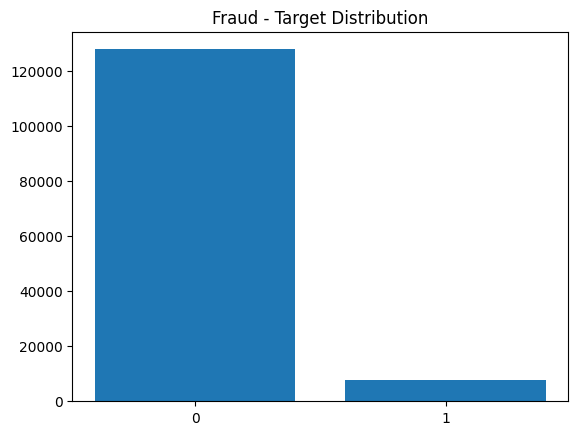

In [82]:
fraudactivities = client_train.groupby(['target'])['client_id'].count()
plt.bar(x=fraudactivities.index, height=fraudactivities.values, tick_label = [0,1])
plt.title('Fraud - Target Distribution')
plt.show()

Target is highly imbalanced with fewer cases of fraudulent activities

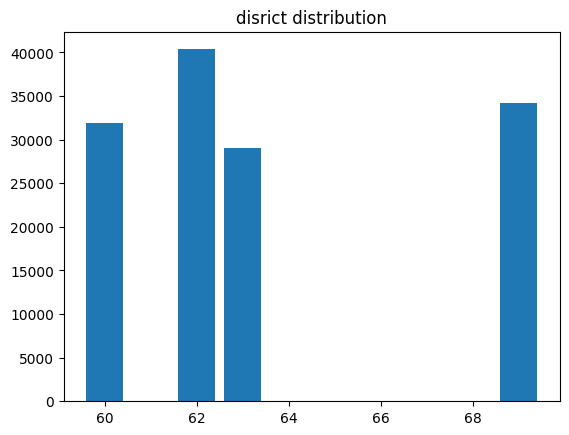

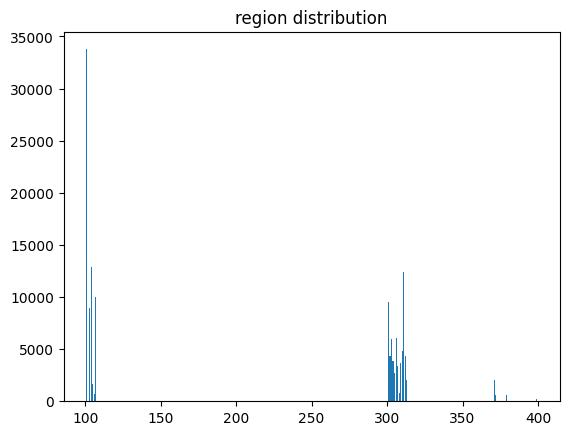

In [83]:
#Visualize client distribution across districts and regions
for col in ['disrict','region']:
    region = client_train.groupby([col])['client_id'].count()
    plt.bar(x=region.index, height=region.values)
#     sns.barplot(x = region.index, y = region.values)
    plt.title(col+' distribution')
    plt.show()

In [84]:
client_train['creation_date'] = pd.to_datetime(client_train['creation_date'])
client_train['year'] = client_train['creation_date'].dt.year
client_train['month'] = client_train['creation_date'].dt.month
client_train['day'] = client_train['creation_date'].dt.day

client_test['creation_date'] = pd.to_datetime(client_test['creation_date'])
client_test['year'] = client_test['creation_date'].dt.year
client_test['month'] = client_test['creation_date'].dt.month
client_test['day'] = client_test['creation_date'].dt.day

##### Plot the count of fraud against non-fraud clients

The plots are ordered in such a way that columns with a higher proportion of fraud clients appear first

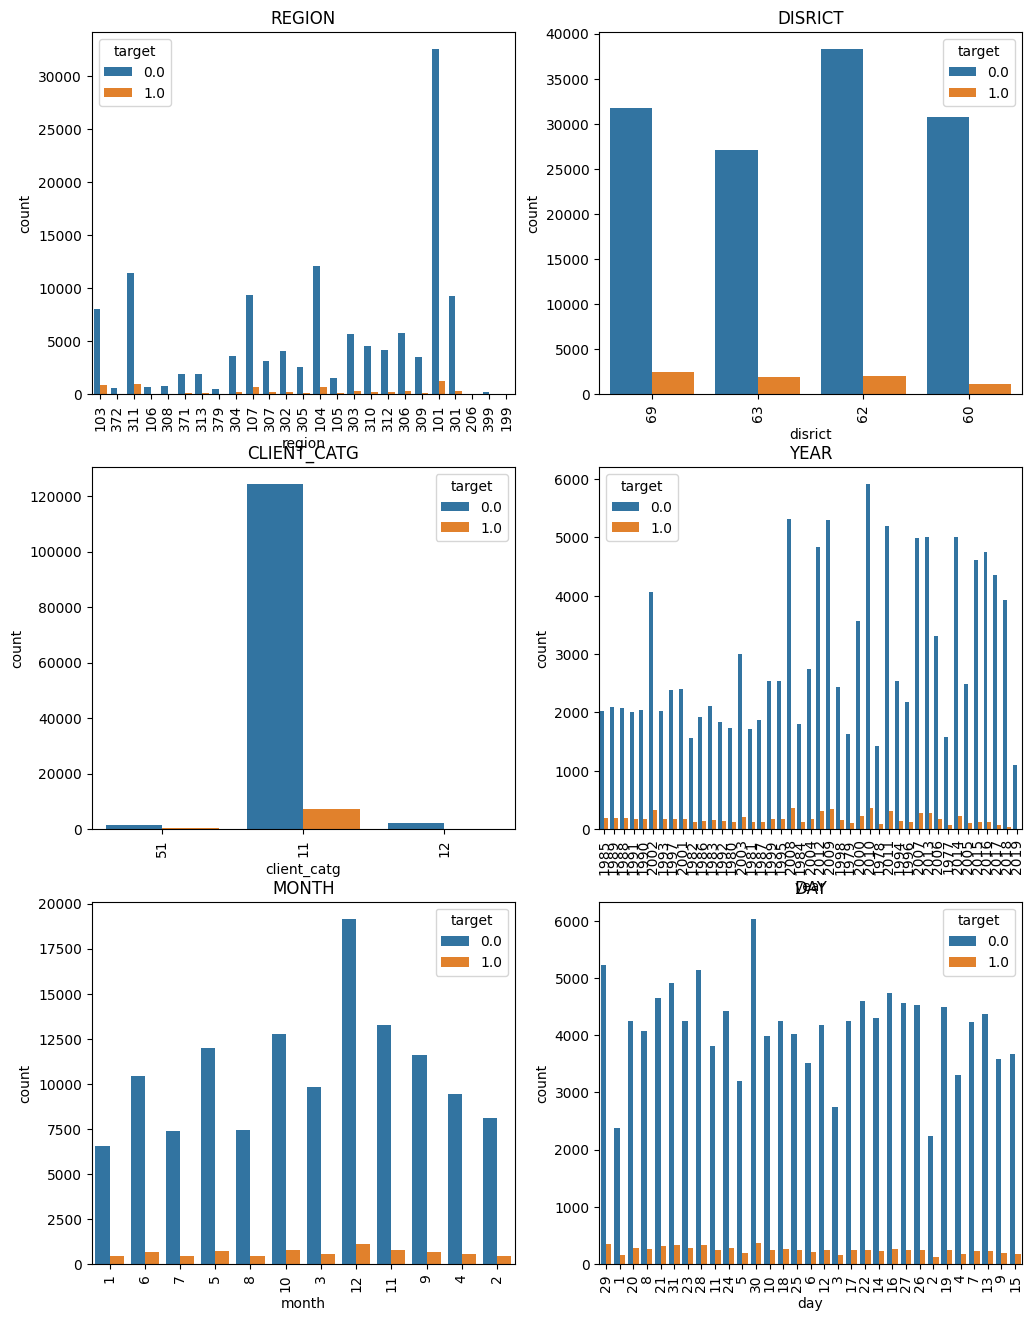

In [86]:
def plot_fraud(dataset, columns, plt_rows, plt_columns):
    plt.figure(figsize= (12, 16))

    for i, column in enumerate(columns):
        plt.subplot(plt_rows, plt_columns, i+1)
        order = dataset.groupby([column])['target'].mean()
        order = order.sort_values(ascending = False).index

        sns.countplot(data = dataset, x = column, hue = 'target', order = order)
        plt.title(column.upper())
        plt.xticks(rotation  =90)
    plt.show()
plot_fraud(client_train, ['region', 'disrict', 'client_catg', "year", 'month', 'day'], 3, 2)

## Feature Engineering

In [93]:
#convert the column invoice_date to date time format on both the invoice train and invoice test
# also create year, month and day columns to reduce value_counts and also see if there is any correlation 

'''
for df in [invoice_train,invoice_test]:
    df['invoice_date'] = pd.to_datetime(df['invoice_date'])
    df['year'] = df['invoice_date'].dt.year
    df['month'] = df['invoice_date'].dt.month
    df['day'] = df['invoice_date'].dt.day    

# The code above took long to execute and therefore decided to save the new datafarame as a csv file
invoice_train.to_csv("train/invoice_train.csv", index = False)
invoice_test.to_csv("test/invoice_test.csv", index = False)
'''

'\nfor df in [invoice_train,invoice_test]:\n    df[\'invoice_date\'] = pd.to_datetime(df[\'invoice_date\'])\n    df[\'year\'] = df[\'invoice_date\'].dt.year\n    df[\'month\'] = df[\'invoice_date\'].dt.month\n    df[\'day\'] = df[\'invoice_date\'].dt.day    \n\n# The code above took long to execute and therefore decided to save the new datafarame as a csv file\ninvoice_train.to_csv("train/invoice_train.csv", index = False)\ninvoice_test.to_csv("test/invoice_test.csv", index = False)\n'

In [94]:
#encode labels in categorical column
d={"ELEC":0,"GAZ":1}
invoice_train['counter_type']=invoice_train['counter_type'].map(d)
invoice_test['counter_type']=invoice_test['counter_type'].map(d)

In [95]:
#convert categorical columns to int for model
client_train['client_catg'] = client_train['client_catg'].astype(int)
client_train['disrict'] = client_train['disrict'].astype(int)

client_test['client_catg'] = client_test['client_catg'].astype(int)
client_test['disrict'] = client_test['disrict'].astype(int)

In [99]:
def aggregate_by_client_id(invoice_data):
    aggs = {}
    aggs['consommation_level_1'] = ['mean']
    aggs['consommation_level_2'] = ['mean']
    aggs['consommation_level_3'] = ['mean']
    aggs['consommation_level_4'] = ['mean']
    # find the mean of each client for the given columns
    agg_trans = invoice_data.groupby(['client_id']).agg(aggs)
    # Rename the columns to include "_mean" at the end
    # agg_trans.columns.values returns [('consommation_level_1', 'mean') ('consommation_level_2', 'mean') ('consommation_level_3', 'mean') ('consommation_level_4', 'mean')]
    agg_trans.columns = ['_'.join(col).strip() for col in agg_trans.columns.values]
    # Indices instead of client_id is used as pivot column
    agg_trans.reset_index(inplace=True)
    # create a new column which holds the value_counts for each client_id
    df = (invoice_data.groupby('client_id')
            .size()
            .reset_index(name='{}transactions_count'.format('1')))
    return pd.merge(df, agg_trans, on='client_id', how='left')
#group invoice data by client_id
agg_train = aggregate_by_client_id(invoice_train)
print(agg_train.shape)
agg_train.head()

(22532, 6)


,client_id,1transactions_count,consommation_level_1_mean,consommation_level_2_mean,consommation_level_3_mean,consommation_level_4_mean
0,train_Client_0,35,352.400000,10.571429,0.000000,0.000000
1,train_Client_1,37,557.540541,0.000000,0.000000,0.000000
2,train_Client_10,18,798.611111,37.888889,0.000000,0.000000
3,train_Client_100,20,1.200000,0.000000,0.000000,0.000000
4,train_Client_1000,14,663.714286,104.857143,117.357143,36.714286


In [100]:
#merge aggregate data with client dataset
train = pd.merge(client_train,agg_train, on='client_id', how='left')

In [121]:
delete_indices = train[train['1transactions_count'].isnull()].index
train.drop(delete_indices, inplace = True)
train.shape

(22532, 14)

In [122]:
#aggregate test set
agg_test = aggregate_by_client_id(invoice_test)
test = pd.merge(client_test,agg_test, on='client_id', how='left')

In [123]:
train.shape, test.shape

((22532, 14), (58069, 13))

In [124]:
#drop redundant columns
sub_client_id = test['client_id']
drop_columns = ['client_id', 'creation_date']

for col in drop_columns:
    if col in train.columns:
        train.drop([col], axis=1, inplace=True)
    if col in test.columns:
        test.drop([col], axis=1, inplace=True)

# Modelling

### Train a baseline model

In [153]:
label = 'target'
valid_size = .3
train = train.reindex(np.random.permutation(train.index))
valid_size = int(len(train) * valid_size)
train_df = train[valid_size:]
valid_df = train[:valid_size]

# convert pd.dataframe to tensorflow datasets
train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(train_df, label = label)
valid_ds = tfdf.keras.pd_dataframe_to_tf_dataset(valid_df, label = label)

# specify the model
base_model = tfdf.keras.RandomForestModel(verbose = 0)
# train model
base_model.fit(train_ds)
# compile the model
base_model.compile(metrics = ['accuracy'])

[INFO 24-03-30 00:15:10.5633 EAT kernel.cc:1233] Loading model from path /tmp/tmp2kh8i29o/model/ with prefix 9a558ef234b14e35
[INFO 24-03-30 00:15:11.2163 EAT decision_forest.cc:734] Model loaded with 300 root(s), 272676 node(s), and 11 input feature(s).
[INFO 24-03-30 00:15:11.2164 EAT abstract_model.cc:1344] Engine "RandomForestOptPred" built
[INFO 24-03-30 00:15:11.2164 EAT kernel.cc:1061] Use fast generic engine


In [154]:
evaluation = base_model.evaluate(valid_ds, return_dict = True)

7/7 [==============================] - 2s 43ms/step - loss: 0.0000e+00 - accuracy: 0.9447


## Train LGBM *Classifier*

In [125]:
x_train = train.drop(columns=['target'])
y_train = train['target']

In [126]:
model = LGBMClassifier(boosting_type='gbdt', num_iterations=500)
model.fit(x_train, y_train)

[LightGBM] [Info] Number of positive: 1271, number of negative: 21261
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.045705 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1289
[LightGBM] [Info] Number of data points in the train set: 22532, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.056409 -> initscore=-2.817070
[LightGBM] [Info] Start training from score -2.817070


LGBMClassifier(num_iterations=500)

In [127]:
x_train.disrict.unique()

array([60, 69, 62, 63])

## Make Predictions on test set

In [128]:
test.columns

Index(['disrict', 'client_catg', 'region', 'year', 'month', 'day',
       '1transactions_count', 'consommation_level_1_mean',
       'consommation_level_2_mean', 'consommation_level_3_mean',
       'consommation_level_4_mean'],
      dtype='object')

In [129]:
preds = model.predict(test)
preds = pd.DataFrame(preds, columns=['target'])
preds.head()

,target
0,0.0
1,0.0
2,0.0
3,0.0
4,0.0


In [130]:
submission = pd.DataFrame(
    {
        'client_id': sub_client_id,
        'target': preds['target']
    }
)

submission.head()

,client_id,target
0,test_Client_0,0.0
1,test_Client_1,0.0
2,test_Client_10,0.0
3,test_Client_100,0.0
4,test_Client_1000,0.0


In [131]:
submission.to_csv(f'{OUTPUT_DIR}/submission.csv', index=False)

## Tips 
- Thorough EDA and incorporating domain knowledge
- Re-grouping categorical features
- More feature engineering(try utilizing some date-time features)
- Target balancing - oversampling, undersampling, SMOTE, scale_pos_weight
- Model ensembling
- Train-test split or cross-validation


# ******************* GOOD LUCK!!! ***************************